# **Introduction to PyTorch** - MLP and MNIST

**AI in Medicine, KACST 2023**

**Code by Ricardo Henao**  

**June 11, 2023**  

> In this notebook, we're going to gain familiarity with the PyTorch deep learning framework by building PyTorch models to perform handwritten digit classification.

## **0. Packages required**

In this example we will be using EHR synthetic data from [pyhealth](https://github.com/sunlabuiuc/PyHealth), so we are installing the package first 

In [2]:
!pip install pyhealth

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.3/226.3 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 68.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 136.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 16.7 MB/s eta 0:00:00
  Created wheel for pandarallel: filename=pandarallel-1.6.5-py3-none-any.whl size=16677 sha256=356a0966df8cff601dd9f0e872d91d1fa867741e6b0199510fa5ff59b66bb097
  Stored in directory: /root/.cache/pip/wheels/50/4f/1e/34e057bb868842209f1623f195b74fd7eda229308a7352d47f
Successfully built pandarallel


Below we instantiate the MLP class that we will be using to train the model on EHR data. The code has been slightly modified from the [pyhealth](https://github.com/sunlabuiuc/PyHealth/blob/master/pyhealth/models/mlp.py) source code.

In [3]:
from typing import Dict, List, Optional, Tuple

import torch
import torch.nn as nn

from pyhealth.datasets import SampleEHRDataset
from pyhealth.models import BaseModel


class MLP(BaseModel):
    """Multi-layer perceptron model.

    This model applies a separate MLP layer for each feature, and then concatenates
    the final hidden states of each MLP layer. The concatenated hidden states are
    then fed into a fully connected layer to make predictions.

    Note:
        We use separate MLP layers for different feature_keys.
        Currentluy, we automatically support different input formats:
            - code based input (need to use the embedding table later)
            - float/int based value input
        We follow the current convention for the rnn model:
            - case 1. [code1, code2, code3, ...]
                - we will assume the code follows the order; our model will encode
                each code into a vector; we use mean/sum pooling and then MLP
            - case 2. [[code1, code2]] or [[code1, code2], [code3, code4, code5], ...]
                - we first use the embedding table to encode each code into a vector
                and then use mean/sum pooling to get one vector for each sample; we then
                use MLP layers
            - case 3. [1.5, 2.0, 0.0]
                - we run MLP directly
            - case 4. [[1.5, 2.0, 0.0]] or [[1.5, 2.0, 0.0], [8, 1.2, 4.5], ...]
                - This case only makes sense when each inner bracket has the same length;
                we assume each dimension has the same meaning; we use mean/sum pooling
                within each outer bracket and use MLP, similar to case 1 after embedding table
            - case 5. [[[1.5, 2.0, 0.0]]] or [[[1.5, 2.0, 0.0], [8, 1.2, 4.5]], ...]
                - This case only makes sense when each inner bracket has the same length;
                we assume each dimension has the same meaning; we use mean/sum pooling
                within each outer bracket and use MLP, similar to case 2 after embedding table

    Args:
        dataset: the dataset to train the model. It is used to query certain
            information such as the set of all tokens.
        feature_keys:  list of keys in samples to use as features,
            e.g. ["conditions", "procedures"].
        label_key: key in samples to use as label (e.g., "drugs").
        mode: one of "binary", "multiclass", or "multilabel".
        embedding_dim: the embedding dimension. Default is 128.
        hidden_dim: the hidden dimension. Default is 128.
        n_layers: the number of layers. Default is 2.
        activation: the activation function. Default is "relu".
        **kwargs: other parameters for the RNN layer.

    Examples:
        >>> from pyhealth.datasets import SampleEHRDataset
        >>> samples = [
        ...         {
        ...             "patient_id": "patient-0",
        ...             "visit_id": "visit-0",
        ...             "conditions": ["cond-33", "cond-86", "cond-80"],
        ...             "procedures": [1.0, 2.0, 3.5, 4],
        ...             "label": 0,
        ...         },
        ...         {
        ...             "patient_id": "patient-0",
        ...             "visit_id": "visit-0",
        ...             "conditions": ["cond-33", "cond-86", "cond-80"],
        ...             "procedures": [5.0, 2.0, 3.5, 4],
        ...             "label": 1,
        ...         },
        ...     ]
        >>> dataset = SampleEHRDataset(samples=samples, dataset_name="test")
        >>>
        >>> from pyhealth.models import MLP
        >>> model = MLP(
        ...         dataset=dataset,
        ...         feature_keys=["conditions", "procedures"],
        ...         label_key="label",
        ...         mode="binary",
        ...     )
        >>>
        >>> from pyhealth.datasets import get_dataloader
        >>> train_loader = get_dataloader(dataset, batch_size=2, shuffle=True)
        >>> data_batch = next(iter(train_loader))
        >>>
        >>> ret = model(**data_batch)
        >>> print(ret)
        {
            'loss': tensor(0.6659, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
            'y_prob': tensor([[0.5680],
                            [0.5352]], grad_fn=<SigmoidBackward0>),
            'y_true': tensor([[1.],
                            [0.]]),
            'logit': tensor([[0.2736],
                            [0.1411]], grad_fn=<AddmmBackward0>)
        }
        >>>

    """

    def __init__(
        self,
        dataset: SampleEHRDataset,
        feature_keys: List[str],
        label_key: str,
        mode: str,
        embedding_dim: int = 128,
        hidden_dim: int = 128,
        n_layers: int = 2,
        activation: str = "relu",
        **kwargs,
    ):
        super(MLP, self).__init__(
            dataset=dataset,
            feature_keys=feature_keys,
            label_key=label_key,
            mode=mode,
        )
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        # validate kwargs for RNN layer
        if "input_size" in kwargs:
            raise ValueError("input_size is determined by embedding_dim")
        if "hidden_size" in kwargs:
            raise ValueError("hidden_size is determined by hidden_dim")

        # the key of self.feat_tokenizers only contains the code based inputs
        self.feat_tokenizers = {}
        self.label_tokenizer = self.get_label_tokenizer()
        # the key of self.embeddings only contains the code based inputs
        self.embeddings = nn.ModuleDict()
        # the key of self.linear_layers only contains the float/int based inputs
        self.linear_layers = nn.ModuleDict()

        # add feature MLP layers
        for feature_key in self.feature_keys:
            input_info = self.dataset.input_info[feature_key]
            # sanity check
            if input_info["type"] not in [str, float, int]:
                raise ValueError(
                    "MLP only supports str code, float and int as input types"
                )
            elif (input_info["type"] == str) and (input_info["dim"] not in [1, 2, 3]):
                raise ValueError(
                    "MLP only supports 1-dim or 2-dim str code as input types"
                )
            elif (input_info["type"] in [float, int]) and (
                input_info["dim"] not in [1, 2, 3]
            ):
                raise ValueError(
                    "MLP only supports 1-dim, 2-dim or 3-dim float and int as input types"
                )
            # for code based input, we need Type
            # for float/int based input, we need Type, input_dim
            self.add_feature_transform_layer(feature_key, input_info)

        if activation == "relu":
            self.activation = nn.ReLU()
        elif activation == "tanh":
            self.activation = nn.Tanh()
        elif activation == "sigmoid":
            self.activation = nn.Sigmoid()
        elif activation == "leaky_relu":
            self.activation = nn.LeakyReLU()
        elif activation == "elu":
            self.activation = nn.ELU()
        else:
            raise ValueError(f"Unsupported activation function {activation}")

        self.mlp = nn.ModuleDict()
        for feature_key in feature_keys:
            Modules = []
            Modules.append(nn.Linear(self.embedding_dim, self.hidden_dim))
            for _ in range(self.n_layers - 1):
                Modules.append(self.activation)
                Modules.append(nn.Linear(self.hidden_dim, self.hidden_dim))
            self.mlp[feature_key] = nn.Sequential(*Modules)

        output_size = self.get_output_size(self.label_tokenizer)
        self.fc = nn.Linear(len(self.feature_keys) * self.hidden_dim, output_size)

    @staticmethod
    def mean_pooling(x, mask):
        """Mean pooling over the middle dimension of the tensor.
        Args:
            x: tensor of shape (batch_size, seq_len, embedding_dim)
            mask: tensor of shape (batch_size, seq_len)
        Returns:
            x: tensor of shape (batch_size, embedding_dim)
        Examples:
            >>> x.shape
            [128, 5, 32]
            >>> mean_pooling(x).shape
            [128, 32]
        """
        return x.sum(dim=1) / mask.sum(dim=1, keepdim=True)

    @staticmethod
    def sum_pooling(x):
        """Mean pooling over the middle dimension of the tensor.
        Args:
            x: tensor of shape (batch_size, seq_len, embedding_dim)
            mask: tensor of shape (batch_size, seq_len)
        Returns:
            x: tensor of shape (batch_size, embedding_dim)
        Examples:
            >>> x.shape
            [128, 5, 32]
            >>> sum_pooling(x).shape
            [128, 32]
        """
        return x.sum(dim=1)

    def forward(self, **kwargs) -> Dict[str, torch.Tensor]:
        """Forward propagation.

        The label `kwargs[self.label_key]` is a list of labels for each patient.

        Args:
            **kwargs: keyword arguments for the model. The keys must contain
                all the feature keys and the label key.

        Returns:
            A dictionary with the following keys:
                loss: a scalar tensor representing the loss.
                y_prob: a tensor representing the predicted probabilities.
                y_true: a tensor representing the true labels.
        """
        patient_emb = []
        for feature_key in self.feature_keys:
            input_info = self.dataset.input_info[feature_key]
            dim_, type_ = input_info["dim"], input_info["type"]

            # for case 1: [code1, code2, code3, ...]
            if (dim_ == 2) and (type_ == str):
                x = self.feat_tokenizers[feature_key].batch_encode_2d(
                    kwargs[feature_key]
                )
                # (patient, event)
                x = torch.tensor(x, dtype=torch.long, device=self.device)
                # (patient, event, embedding_dim)
                x = self.embeddings[feature_key](x)
                # (patient, event)
                mask = torch.any(x !=0, dim=2)
                # (patient, embedding_dim)
                x = self.mean_pooling(x, mask)

            # for case 2: [[code1, code2], [code3, ...], ...]
            elif (dim_ == 3) and (type_ == str):
                x = self.feat_tokenizers[feature_key].batch_encode_3d(
                    kwargs[feature_key]
                )
                # (patient, visit, event)
                x = torch.tensor(x, dtype=torch.long, device=self.device)
                # (patient, visit, event, embedding_dim)
                x = self.embeddings[feature_key](x)
                # (patient, visit, embedding_dim)
                x = torch.sum(x, dim=2)
                # (patient, visit)
                mask = torch.any(x !=0, dim=2)
                # (patient, embedding_dim)
                x = self.mean_pooling(x, mask)

            # for case 3: [1.5, 2.0, 0.0]
            elif (dim_ == 1) and (type_ in [float, int]):
                # (patient, values)
                x = torch.tensor(
                    kwargs[feature_key], dtype=torch.float, device=self.device
                )
                # (patient, embedding_dim)
                x = self.linear_layers[feature_key](x)

            # for case 4: [[1.5, 2.0, 0.0], ...]
            elif (dim_ == 2) and (type_ in [float, int]):
                x, mask = self.padding2d(kwargs[feature_key])
                # (patient, event, values)
                x = torch.tensor(x, dtype=torch.float, device=self.device)
                # (patient, event, embedding_dim)
                x = self.linear_layers[feature_key](x)
                # (patient, event)
                mask = torch.tensor(mask, dtype=torch.bool, device=self.device)
                # (patient, embedding_dim)
                x = self.mean_pooling(x, mask)

            # for case 5: [[[1.5, 2.0, 0.0], [1.8, 2.4, 6.0]], ...]
            elif (dim_ == 3) and (type_ in [float, int]):
                x, mask = self.padding3d(kwargs[feature_key])
                # (patient, visit, event, values)
                x = torch.tensor(x, dtype=torch.float, device=self.device)
                # (patient, visit, embedding_dim)
                x = self.linear_layers[feature_key](x)
                # (patient, event)
                mask = torch.tensor(mask, dtype=torch.bool, device=self.device)
                # (patient, embedding_dim)
                x = self.mean_pooling(x, mask)

            else:
                raise NotImplementedError

            x = self.mlp[feature_key](x)
            patient_emb.append(x)

        patient_emb = torch.cat(patient_emb, dim=1)
        # (patient, label_size)
        logits = self.fc(patient_emb)
        # obtain y_true, loss, y_prob
        y_true = self.prepare_labels(kwargs[self.label_key], self.label_tokenizer)
        loss = self.get_loss_function()(logits, y_true)
        y_prob = self.prepare_y_prob(logits)
        results = {
            "loss": loss,
            "y_prob": y_prob,
            "y_true": y_true,
            "logit": logits,
        }
        if kwargs.get("embed", False):
            results["embed"] = patient_emb
        return results

## **1. Setting Up the Enivronment**

### 1.1. Import utilities

First, we need to import necessary libraries, modules, and functions we'll use throughout this tutorial. We are only using functions from the [pyhealth](https://github.com/sunlabuiuc/PyHealth) package, which implement dataset instantiation, processing, data loader creation and model training via [pytorch](https://pytorch.org/).

In [4]:
# Define random state
random_state = 0

# Import libraries, modules, and functions
from pyhealth.datasets import MIMIC3Dataset
from pyhealth.tasks import length_of_stay_prediction_mimic3_fn
from pyhealth.datasets.splitter import split_by_patient
from pyhealth.datasets import split_by_patient, get_dataloader
from pyhealth.trainer import Trainer
from pyhealth.medcode import InnerMap
from pyhealth.metrics.multiclass import multiclass_metrics_fn

/usr/local/lib/python3.10/dist-packages/pyhealth/trainer.py:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange


## **2. Loading and Preparing the Data**

One of the first (and often most important) steps in a machine learning pipeline is preparing the data. Here, we will load an artificial dataset based on [MIMIC-III](https://physionet.org/content/mimiciii/1.4/) EHR data.

### 2.1. Load EHR data

For additional details about the datasets see [pyhealth.datasets](https://pyhealth.readthedocs.io/en/latest/api/datasets.html). The library currently provides [MIMIC3Dataset](https://pyhealth.readthedocs.io/en/latest/api/datasets/pyhealth.datasets.MIMIC3Dataset.html), [MIMIC4Dataset](https://pyhealth.readthedocs.io/en/latest/api/datasets/pyhealth.datasets.MIMIC4Dataset.html), [eICUDataset](https://pyhealth.readthedocs.io/en/latest/api/datasets/pyhealth.datasets.eICUDataset.html), [OMOPDataset](https://pyhealth.readthedocs.io/en/latest/api/datasets/pyhealth.datasets.OMOPDataset.html).

In [5]:
mimic3_ds = MIMIC3Dataset(
        root="https://storage.googleapis.com/pyhealth/Synthetic_MIMIC-III/",
        tables=["DIAGNOSES_ICD", "PROCEDURES_ICD", "PRESCRIPTIONS"],
        code_mapping={},
        dev=True,
)

mimic3_ds.stat()

INFO: Pandarallel will run on 1 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
finish basic patient information parsing : 1.9789574146270752s
finish parsing DIAGNOSES_ICD : 1.519651174545288s
finish parsing PROCEDURES_ICD : 1.0078527927398682s
finish parsing PRESCRIPTIONS : 6.417688846588135s


Mapping codes: 100%|██████████| 1000/1000 [00:00<00:00, 42316.70it/s]


Statistics of base dataset (dev=True):
	- Dataset: MIMIC3Dataset
	- Number of patients: 1000
	- Number of visits: 1054
	- Number of visits per patient: 1.0540
	- Number of events per visit in DIAGNOSES_ICD: 9.2068
	- Number of events per visit in PROCEDURES_ICD: 3.0380
	- Number of events per visit in PRESCRIPTIONS: 29.2457



'\nStatistics of base dataset (dev=True):\n\t- Dataset: MIMIC3Dataset\n\t- Number of patients: 1000\n\t- Number of visits: 1054\n\t- Number of visits per patient: 1.0540\n\t- Number of events per visit in DIAGNOSES_ICD: 9.2068\n\t- Number of events per visit in PROCEDURES_ICD: 3.0380\n\t- Number of events per visit in PRESCRIPTIONS: 29.2457\n'

### 2.1. EHR data structure

The dataset is organized in a hierarchical way where patients have multiple visits and each visit has multiple events. Each level has its own data, namely, patient data, visit data and event data (diagnosos, procedures and medications in the example above).

The image below is taken from [pyhealth](https://pyhealth.readthedocs.io/en/latest/tutorials.html)

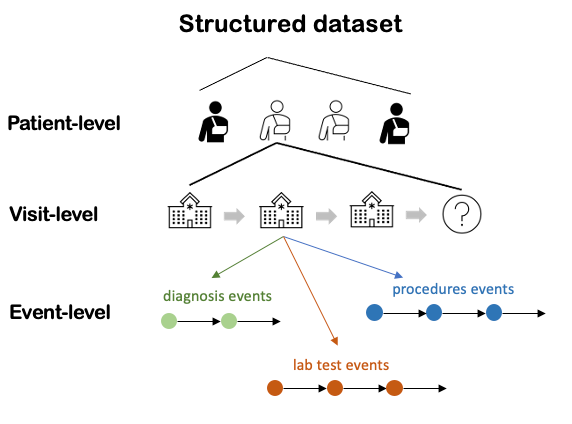

## 2.3 Dataset Information

Below we examine the structure of the dataset, which is organized into patients, visits and events.

In [6]:
mimic3_ds.info()


dataset.patients: patient_id -> <Patient>

<Patient>
    - visits: visit_id -> <Visit> 
    - other patient-level info
    
    <Visit>
        - event_list_dict: table_name -> List[Event]
        - other visit-level info
    
        <Event>
            - code: str
            - other event-level info



In [7]:
vars( mimic3_ds.patients['1'] )

{'patient_id': '1',
 'birth_datetime': datetime.datetime(2102, 9, 7, 0, 0),
 'death_datetime': None,
 'gender': 'M',
 'ethnicity': 'UNABLE TO OBTAIN',
 'attr_dict': {},
 'visits': OrderedDict([('100000',
               Visit 100000 from patient 1 with 36 events from tables ['DIAGNOSES_ICD', 'PROCEDURES_ICD', 'PRESCRIPTIONS'])]),
 'index_to_visit_id': {0: '100000'}}

In [8]:
mimic3_ds.patients['1'].visits['100000']

Visit 100000 from patient 1 with 36 events from tables ['DIAGNOSES_ICD', 'PROCEDURES_ICD', 'PRESCRIPTIONS']

In [9]:
mimic3_ds.patients['1'].visits['100000'].get_event_list('DIAGNOSES_ICD')

[Event with ICD9CM code 86121 from table DIAGNOSES_ICD,
 Event with ICD9CM code V4589 from table DIAGNOSES_ICD,
 Event with ICD9CM code 25082 from table DIAGNOSES_ICD,
 Event with ICD9CM code 79902 from table DIAGNOSES_ICD,
 Event with ICD9CM code 19889 from table DIAGNOSES_ICD,
 Event with ICD9CM code 36201 from table DIAGNOSES_ICD,
 Event with ICD9CM code 99681 from table DIAGNOSES_ICD,
 Event with ICD9CM code 27802 from table DIAGNOSES_ICD,
 Event with ICD9CM code 30593 from table DIAGNOSES_ICD]

In [10]:
mimic3_ds.patients['1'].visits['100000'].get_event_list('PROCEDURES_ICD')

[Event with ICD9PROC code 3895 from table PROCEDURES_ICD,
 Event with ICD9PROC code 544 from table PROCEDURES_ICD,
 Event with ICD9PROC code 9618 from table PROCEDURES_ICD,
 Event with ICD9PROC code 8472 from table PROCEDURES_ICD]

In [11]:
mimic3_ds.patients['1'].visits['100000'].get_event_list('PRESCRIPTIONS')

[Event with NDC code 00008092355 from table PRESCRIPTIONS,
 Event with NDC code 00338001702 from table PRESCRIPTIONS,
 Event with NDC code 00641040025 from table PRESCRIPTIONS,
 Event with NDC code 00517090125 from table PRESCRIPTIONS,
 Event with NDC code 00517391025 from table PRESCRIPTIONS,
 Event with NDC code 00338070341 from table PRESCRIPTIONS,
 Event with NDC code 00074233411 from table PRESCRIPTIONS,
 Event with NDC code 00182844789 from table PRESCRIPTIONS,
 Event with NDC code 63739008901 from table PRESCRIPTIONS,
 Event with NDC code 66689036430 from table PRESCRIPTIONS,
 Event with NDC code 00074241512 from table PRESCRIPTIONS,
 Event with NDC code 00074131230 from table PRESCRIPTIONS,
 Event with NDC code 00904526161 from table PRESCRIPTIONS,
 Event with NDC code 00006494300 from table PRESCRIPTIONS,
 Event with NDC code 00406051201 from table PRESCRIPTIONS,
 Event with NDC code 00004200278 from table PRESCRIPTIONS,
 Event with NDC code 00045025501 from table PRESCRIPTION

In [12]:
icd9cm = InnerMap.load("ICD9CM")
icd9proc = InnerMap.load("ICD9PROC")
# ndc = InnerMap.load("NDC")

print(icd9cm.lookup("86121"))
print(icd9proc.lookup("3895"))
# print(ndc.lookup("00008092355"))

Contusion of lung without mention of open wound into thorax
Venous catheterization for renal dialysis


### 2.4 Define EHR Task

Below we assigns a **task function** to the dataset for data loading [pyhealth.tasks](https://pyhealth.readthedocs.io/en/latest/api/tasks.html). The **task function** specifics how to process each pateint's data into a set of samples for the downstream machine learning models.

We will be trying to predict length of stay (LOS). However, to be able to treat it as a classification problem we are binning LOS, specifically, 0: less than 1 day, 1-7: 1-7 days, 8: 8-14 days, and 9: longer than two weeks.

In [13]:
# define task
task_mimic3_ds = mimic3_ds.set_task(task_fn=length_of_stay_prediction_mimic3_fn)

# stats info
task_mimic3_ds.stat()

Generating samples for length_of_stay_prediction_mimic3_fn: 100%|██████████| 1000/1000 [00:00<00:00, 43826.25it/s]

Statistics of sample dataset:
	- Dataset: MIMIC3Dataset
	- Task: length_of_stay_prediction_mimic3_fn
	- Number of samples: 896
	- Number of patients: 886
	- Number of visits: 896
	- Number of visits per patient: 1.0113
	- conditions:
		- Number of conditions per sample: 9.7377
		- Number of unique conditions: 1699
		- Distribution of conditions (Top-10): [('4019', 324), ('41401', 167), ('25000', 151), ('4280', 147), ('5849', 121), ('2724', 118), ('42731', 110), ('51881', 89), ('53081', 88), ('2720', 85)]
	- procedures:
		- Number of procedures per sample: 3.5647
		- Number of unique procedures: 558
		- Distribution of procedures (Top-10): [('3893', 155), ('9671', 139), ('9604', 123), ('9904', 100), ('8856', 85), ('966', 64), ('3615', 61), ('3961', 59), ('3722', 58), ('3891', 55)]
	- drugs:
		- Number of drugs per sample: 32.5804
		- Number of unique drugs: 1911
		- Distribution of drugs (Top-10): [('00338004904', 388), ('00008084199', 362), ('00338004903', 317), ('00338001702', 305), (

"Statistics of sample dataset:\n\t- Dataset: MIMIC3Dataset\n\t- Task: length_of_stay_prediction_mimic3_fn\n\t- Number of samples: 896\n\t- Number of patients: 886\n\t- Number of visits: 896\n\t- Number of visits per patient: 1.0113\n\t- conditions:\n\t\t- Number of conditions per sample: 9.7377\n\t\t- Number of unique conditions: 1699\n\t\t- Distribution of conditions (Top-10): [('4019', 324), ('41401', 167), ('25000', 151), ('4280', 147), ('5849', 121), ('2724', 118), ('42731', 110), ('51881', 89), ('53081', 88), ('2720', 85)]\n\t- procedures:\n\t\t- Number of procedures per sample: 3.5647\n\t\t- Number of unique procedures: 558\n\t\t- Distribution of procedures (Top-10): [('3893', 155), ('9671', 139), ('9604', 123), ('9904', 100), ('8856', 85), ('966', 64), ('3615', 61), ('3961', 59), ('3722', 58), ('3891', 55)]\n\t- drugs:\n\t\t- Number of drugs per sample: 32.5804\n\t\t- Number of unique drugs: 1911\n\t\t- Distribution of drugs (Top-10): [('00338004904', 388), ('00008084199', 362),

## 2.5 Data split

Let us split the dataset into training, validation and test with proportions 80%, 10% and 10%, respectively. Then for each subset we can create data loaders.

In [14]:
# data split
train_dataset, val_dataset, test_dataset = split_by_patient(task_mimic3_ds, [0.8, 0.1, 0.1])

# create dataloaders (they are <torch.data.DataLoader> object)
train_loader = get_dataloader(train_dataset, batch_size=64, shuffle=True)
val_loader = get_dataloader(val_dataset, batch_size=64, shuffle=False)
test_loader = get_dataloader(test_dataset, batch_size=64, shuffle=False)

## 2.6 Define Model for Mortality Prediction

For this example, we will use an MLP to predict binned LOS from diagnosis, procedures and medications.

In [22]:
model = MLP(
    dataset=task_mimic3_ds,
    # look up what are available for "feature_keys" and "label_keys" in dataset.samples[0]
    feature_keys=["procedures","conditions","drugs"],
    label_key="label",
    mode="multiclass",
    num_layers=4,
)

## 2.7 Model Training

We are training the model for 5 epochs using weighted jaccard as the metric on the validation set to monitor convergence.

In [23]:
trainer = Trainer(model=model, metrics=["accuracy", "jaccard_weighted"])

trainer.train(
    train_dataloader=train_loader,
    val_dataloader=val_loader,
    epochs=20,
    monitor="jaccard_weighted",
)

MLP(
  (embeddings): ModuleDict(
    (procedures): Embedding(560, 128, padding_idx=0)
    (conditions): Embedding(1701, 128, padding_idx=0)
    (drugs): Embedding(1913, 128, padding_idx=0)
  )
  (linear_layers): ModuleDict()
  (activation): ReLU()
  (mlp): ModuleDict(
    (procedures): Sequential(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
    )
    (conditions): Sequential(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
    )
    (drugs): Sequential(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
    )
  )
  (fc): Linear(in_features=384, out_features=10, bias=True)
)


INFO:pyhealth.trainer:MLP(
  (embeddings): ModuleDict(
    (procedures): Embedding(560, 128, padding_idx=0)
    (conditions): Embedding(1701, 128, padding_idx=0)
    (drugs): Embedding(1913, 128, padding_idx=0)
  )
  (linear_layers): ModuleDict()
  (activation): ReLU()
  (mlp): ModuleDict(
    (procedures): Sequential(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
    )
    (conditions): Sequential(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
    )
    (drugs): Sequential(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
    )
  )
  (fc): Linear(in_features=384, out_features=10, bias=True)
)


Metrics: ['accuracy', 'jaccard_weighted']


INFO:pyhealth.trainer:Metrics: ['accuracy', 'jaccard_weighted']


Device: cpu


INFO:pyhealth.trainer:Device: cpu


INFO:pyhealth.trainer:


Training:


INFO:pyhealth.trainer:Training:


Batch size: 64


INFO:pyhealth.trainer:Batch size: 64


Optimizer: <class 'torch.optim.adam.Adam'>


INFO:pyhealth.trainer:Optimizer: <class 'torch.optim.adam.Adam'>


Optimizer params: {'lr': 0.001}


INFO:pyhealth.trainer:Optimizer params: {'lr': 0.001}


Weight decay: 0.0


INFO:pyhealth.trainer:Weight decay: 0.0


Max grad norm: None


INFO:pyhealth.trainer:Max grad norm: None


Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x7fa4c98da950>


INFO:pyhealth.trainer:Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x7fa4c98da950>


Monitor: jaccard_weighted


INFO:pyhealth.trainer:Monitor: jaccard_weighted


Monitor criterion: max


INFO:pyhealth.trainer:Monitor criterion: max


Epochs: 20


INFO:pyhealth.trainer:Epochs: 20


INFO:pyhealth.trainer:


Epoch 0 / 20:   0%|          | 0/12 [00:00<?, ?it/s]

--- Train epoch-0, step-12 ---


INFO:pyhealth.trainer:--- Train epoch-0, step-12 ---


loss: 2.1398


INFO:pyhealth.trainer:loss: 2.1398
Evaluation: 100%|██████████| 2/2 [00:00<00:00, 156.30it/s]


--- Eval epoch-0, step-12 ---


INFO:pyhealth.trainer:--- Eval epoch-0, step-12 ---


accuracy: 0.3297


INFO:pyhealth.trainer:accuracy: 0.3297


jaccard_weighted: 0.1732


INFO:pyhealth.trainer:jaccard_weighted: 0.1732


loss: 2.0577


INFO:pyhealth.trainer:loss: 2.0577


New best jaccard_weighted score (0.1732) at epoch-0, step-12


INFO:pyhealth.trainer:New best jaccard_weighted score (0.1732) at epoch-0, step-12


INFO:pyhealth.trainer:


Epoch 1 / 20:   0%|          | 0/12 [00:00<?, ?it/s]

--- Train epoch-1, step-24 ---


INFO:pyhealth.trainer:--- Train epoch-1, step-24 ---


loss: 1.6484


INFO:pyhealth.trainer:loss: 1.6484
Evaluation: 100%|██████████| 2/2 [00:00<00:00, 252.57it/s]

--- Eval epoch-1, step-24 ---



INFO:pyhealth.trainer:--- Eval epoch-1, step-24 ---


accuracy: 0.3407


INFO:pyhealth.trainer:accuracy: 0.3407


jaccard_weighted: 0.1860


INFO:pyhealth.trainer:jaccard_weighted: 0.1860


loss: 2.0832


INFO:pyhealth.trainer:loss: 2.0832


New best jaccard_weighted score (0.1860) at epoch-1, step-24


INFO:pyhealth.trainer:New best jaccard_weighted score (0.1860) at epoch-1, step-24


INFO:pyhealth.trainer:


Epoch 2 / 20:   0%|          | 0/12 [00:00<?, ?it/s]

--- Train epoch-2, step-36 ---


INFO:pyhealth.trainer:--- Train epoch-2, step-36 ---


loss: 1.3747


INFO:pyhealth.trainer:loss: 1.3747
Evaluation: 100%|██████████| 2/2 [00:00<00:00, 184.97it/s]


--- Eval epoch-2, step-36 ---


INFO:pyhealth.trainer:--- Eval epoch-2, step-36 ---


accuracy: 0.3516


INFO:pyhealth.trainer:accuracy: 0.3516


jaccard_weighted: 0.1867


INFO:pyhealth.trainer:jaccard_weighted: 0.1867


loss: 2.0157


INFO:pyhealth.trainer:loss: 2.0157


New best jaccard_weighted score (0.1867) at epoch-2, step-36


INFO:pyhealth.trainer:New best jaccard_weighted score (0.1867) at epoch-2, step-36


INFO:pyhealth.trainer:


Epoch 3 / 20:   0%|          | 0/12 [00:00<?, ?it/s]

--- Train epoch-3, step-48 ---


INFO:pyhealth.trainer:--- Train epoch-3, step-48 ---


loss: 1.0617


INFO:pyhealth.trainer:loss: 1.0617
Evaluation: 100%|██████████| 2/2 [00:00<00:00, 231.92it/s]


--- Eval epoch-3, step-48 ---


INFO:pyhealth.trainer:--- Eval epoch-3, step-48 ---


accuracy: 0.3297


INFO:pyhealth.trainer:accuracy: 0.3297


jaccard_weighted: 0.1801


INFO:pyhealth.trainer:jaccard_weighted: 0.1801


loss: 2.1288


INFO:pyhealth.trainer:loss: 2.1288


INFO:pyhealth.trainer:


Epoch 4 / 20:   0%|          | 0/12 [00:00<?, ?it/s]

--- Train epoch-4, step-60 ---


INFO:pyhealth.trainer:--- Train epoch-4, step-60 ---


loss: 0.7865


INFO:pyhealth.trainer:loss: 0.7865
Evaluation: 100%|██████████| 2/2 [00:00<00:00, 169.52it/s]

--- Eval epoch-4, step-60 ---



INFO:pyhealth.trainer:--- Eval epoch-4, step-60 ---


accuracy: 0.2967


INFO:pyhealth.trainer:accuracy: 0.2967


jaccard_weighted: 0.1890


INFO:pyhealth.trainer:jaccard_weighted: 0.1890


loss: 2.2475


INFO:pyhealth.trainer:loss: 2.2475


New best jaccard_weighted score (0.1890) at epoch-4, step-60


INFO:pyhealth.trainer:New best jaccard_weighted score (0.1890) at epoch-4, step-60


INFO:pyhealth.trainer:


Epoch 5 / 20:   0%|          | 0/12 [00:00<?, ?it/s]

--- Train epoch-5, step-72 ---


INFO:pyhealth.trainer:--- Train epoch-5, step-72 ---


loss: 0.5340


INFO:pyhealth.trainer:loss: 0.5340
Evaluation: 100%|██████████| 2/2 [00:00<00:00, 147.51it/s]


--- Eval epoch-5, step-72 ---


INFO:pyhealth.trainer:--- Eval epoch-5, step-72 ---


accuracy: 0.2967


INFO:pyhealth.trainer:accuracy: 0.2967


jaccard_weighted: 0.1833


INFO:pyhealth.trainer:jaccard_weighted: 0.1833


loss: 2.3723


INFO:pyhealth.trainer:loss: 2.3723


INFO:pyhealth.trainer:


Epoch 6 / 20:   0%|          | 0/12 [00:00<?, ?it/s]

--- Train epoch-6, step-84 ---


INFO:pyhealth.trainer:--- Train epoch-6, step-84 ---


loss: 0.3422


INFO:pyhealth.trainer:loss: 0.3422
Evaluation: 100%|██████████| 2/2 [00:00<00:00, 157.55it/s]


--- Eval epoch-6, step-84 ---


INFO:pyhealth.trainer:--- Eval epoch-6, step-84 ---


accuracy: 0.3187


INFO:pyhealth.trainer:accuracy: 0.3187


jaccard_weighted: 0.1990


INFO:pyhealth.trainer:jaccard_weighted: 0.1990


loss: 2.5377


INFO:pyhealth.trainer:loss: 2.5377


New best jaccard_weighted score (0.1990) at epoch-6, step-84


INFO:pyhealth.trainer:New best jaccard_weighted score (0.1990) at epoch-6, step-84


INFO:pyhealth.trainer:


Epoch 7 / 20:   0%|          | 0/12 [00:00<?, ?it/s]

--- Train epoch-7, step-96 ---


INFO:pyhealth.trainer:--- Train epoch-7, step-96 ---


loss: 0.2203


INFO:pyhealth.trainer:loss: 0.2203
Evaluation: 100%|██████████| 2/2 [00:00<00:00, 177.84it/s]

--- Eval epoch-7, step-96 ---



INFO:pyhealth.trainer:--- Eval epoch-7, step-96 ---


accuracy: 0.3297


INFO:pyhealth.trainer:accuracy: 0.3297


jaccard_weighted: 0.2100


INFO:pyhealth.trainer:jaccard_weighted: 0.2100


loss: 2.7164


INFO:pyhealth.trainer:loss: 2.7164


New best jaccard_weighted score (0.2100) at epoch-7, step-96


INFO:pyhealth.trainer:New best jaccard_weighted score (0.2100) at epoch-7, step-96


INFO:pyhealth.trainer:


Epoch 8 / 20:   0%|          | 0/12 [00:00<?, ?it/s]

--- Train epoch-8, step-108 ---


INFO:pyhealth.trainer:--- Train epoch-8, step-108 ---


loss: 0.1277


INFO:pyhealth.trainer:loss: 0.1277
Evaluation: 100%|██████████| 2/2 [00:00<00:00, 172.29it/s]

--- Eval epoch-8, step-108 ---



INFO:pyhealth.trainer:--- Eval epoch-8, step-108 ---


accuracy: 0.3297


INFO:pyhealth.trainer:accuracy: 0.3297


jaccard_weighted: 0.2054


INFO:pyhealth.trainer:jaccard_weighted: 0.2054


loss: 2.8844


INFO:pyhealth.trainer:loss: 2.8844


INFO:pyhealth.trainer:


Epoch 9 / 20:   0%|          | 0/12 [00:00<?, ?it/s]

--- Train epoch-9, step-120 ---


INFO:pyhealth.trainer:--- Train epoch-9, step-120 ---


loss: 0.0750


INFO:pyhealth.trainer:loss: 0.0750
Evaluation: 100%|██████████| 2/2 [00:00<00:00, 187.03it/s]

--- Eval epoch-9, step-120 ---



INFO:pyhealth.trainer:--- Eval epoch-9, step-120 ---


accuracy: 0.3297


INFO:pyhealth.trainer:accuracy: 0.3297


jaccard_weighted: 0.2034


INFO:pyhealth.trainer:jaccard_weighted: 0.2034


loss: 3.0529


INFO:pyhealth.trainer:loss: 3.0529


INFO:pyhealth.trainer:


Epoch 10 / 20:   0%|          | 0/12 [00:00<?, ?it/s]

--- Train epoch-10, step-132 ---


INFO:pyhealth.trainer:--- Train epoch-10, step-132 ---


loss: 0.0526


INFO:pyhealth.trainer:loss: 0.0526
Evaluation: 100%|██████████| 2/2 [00:00<00:00, 175.38it/s]


--- Eval epoch-10, step-132 ---


INFO:pyhealth.trainer:--- Eval epoch-10, step-132 ---


accuracy: 0.3187


INFO:pyhealth.trainer:accuracy: 0.3187


jaccard_weighted: 0.1984


INFO:pyhealth.trainer:jaccard_weighted: 0.1984


loss: 3.1496


INFO:pyhealth.trainer:loss: 3.1496


INFO:pyhealth.trainer:


Epoch 11 / 20:   0%|          | 0/12 [00:00<?, ?it/s]

--- Train epoch-11, step-144 ---


INFO:pyhealth.trainer:--- Train epoch-11, step-144 ---


loss: 0.0355


INFO:pyhealth.trainer:loss: 0.0355
Evaluation: 100%|██████████| 2/2 [00:00<00:00, 177.22it/s]


--- Eval epoch-11, step-144 ---


INFO:pyhealth.trainer:--- Eval epoch-11, step-144 ---


accuracy: 0.3187


INFO:pyhealth.trainer:accuracy: 0.3187


jaccard_weighted: 0.2011


INFO:pyhealth.trainer:jaccard_weighted: 0.2011


loss: 3.2688


INFO:pyhealth.trainer:loss: 3.2688


INFO:pyhealth.trainer:


Epoch 12 / 20:   0%|          | 0/12 [00:00<?, ?it/s]

--- Train epoch-12, step-156 ---


INFO:pyhealth.trainer:--- Train epoch-12, step-156 ---


loss: 0.0262


INFO:pyhealth.trainer:loss: 0.0262
Evaluation: 100%|██████████| 2/2 [00:00<00:00, 175.10it/s]

--- Eval epoch-12, step-156 ---



INFO:pyhealth.trainer:--- Eval epoch-12, step-156 ---


accuracy: 0.3077


INFO:pyhealth.trainer:accuracy: 0.3077


jaccard_weighted: 0.1941


INFO:pyhealth.trainer:jaccard_weighted: 0.1941


loss: 3.3569


INFO:pyhealth.trainer:loss: 3.3569


INFO:pyhealth.trainer:


Epoch 13 / 20:   0%|          | 0/12 [00:00<?, ?it/s]

--- Train epoch-13, step-168 ---


INFO:pyhealth.trainer:--- Train epoch-13, step-168 ---


loss: 0.0203


INFO:pyhealth.trainer:loss: 0.0203
Evaluation: 100%|██████████| 2/2 [00:00<00:00, 155.54it/s]

--- Eval epoch-13, step-168 ---



INFO:pyhealth.trainer:--- Eval epoch-13, step-168 ---


accuracy: 0.2967


INFO:pyhealth.trainer:accuracy: 0.2967


jaccard_weighted: 0.1855


INFO:pyhealth.trainer:jaccard_weighted: 0.1855


loss: 3.4159


INFO:pyhealth.trainer:loss: 3.4159


INFO:pyhealth.trainer:


Epoch 14 / 20:   0%|          | 0/12 [00:00<?, ?it/s]

--- Train epoch-14, step-180 ---


INFO:pyhealth.trainer:--- Train epoch-14, step-180 ---


loss: 0.0157


INFO:pyhealth.trainer:loss: 0.0157
Evaluation: 100%|██████████| 2/2 [00:00<00:00, 165.49it/s]

--- Eval epoch-14, step-180 ---



INFO:pyhealth.trainer:--- Eval epoch-14, step-180 ---


accuracy: 0.3077


INFO:pyhealth.trainer:accuracy: 0.3077


jaccard_weighted: 0.1911


INFO:pyhealth.trainer:jaccard_weighted: 0.1911


loss: 3.5203


INFO:pyhealth.trainer:loss: 3.5203


INFO:pyhealth.trainer:


Epoch 15 / 20:   0%|          | 0/12 [00:00<?, ?it/s]

--- Train epoch-15, step-192 ---


INFO:pyhealth.trainer:--- Train epoch-15, step-192 ---


loss: 0.0128


INFO:pyhealth.trainer:loss: 0.0128
Evaluation: 100%|██████████| 2/2 [00:00<00:00, 155.68it/s]

--- Eval epoch-15, step-192 ---



INFO:pyhealth.trainer:--- Eval epoch-15, step-192 ---


accuracy: 0.3077


INFO:pyhealth.trainer:accuracy: 0.3077


jaccard_weighted: 0.1901


INFO:pyhealth.trainer:jaccard_weighted: 0.1901


loss: 3.5827


INFO:pyhealth.trainer:loss: 3.5827


INFO:pyhealth.trainer:


Epoch 16 / 20:   0%|          | 0/12 [00:00<?, ?it/s]

--- Train epoch-16, step-204 ---


INFO:pyhealth.trainer:--- Train epoch-16, step-204 ---


loss: 0.0113


INFO:pyhealth.trainer:loss: 0.0113
Evaluation: 100%|██████████| 2/2 [00:00<00:00, 167.20it/s]


--- Eval epoch-16, step-204 ---


INFO:pyhealth.trainer:--- Eval epoch-16, step-204 ---


accuracy: 0.3187


INFO:pyhealth.trainer:accuracy: 0.3187


jaccard_weighted: 0.2003


INFO:pyhealth.trainer:jaccard_weighted: 0.2003


loss: 3.6128


INFO:pyhealth.trainer:loss: 3.6128


INFO:pyhealth.trainer:


Epoch 17 / 20:   0%|          | 0/12 [00:00<?, ?it/s]

--- Train epoch-17, step-216 ---


INFO:pyhealth.trainer:--- Train epoch-17, step-216 ---


loss: 0.0094


INFO:pyhealth.trainer:loss: 0.0094
Evaluation: 100%|██████████| 2/2 [00:00<00:00, 145.49it/s]


--- Eval epoch-17, step-216 ---


INFO:pyhealth.trainer:--- Eval epoch-17, step-216 ---


accuracy: 0.3297


INFO:pyhealth.trainer:accuracy: 0.3297


jaccard_weighted: 0.2078


INFO:pyhealth.trainer:jaccard_weighted: 0.2078


loss: 3.6692


INFO:pyhealth.trainer:loss: 3.6692


INFO:pyhealth.trainer:


Epoch 18 / 20:   0%|          | 0/12 [00:00<?, ?it/s]

--- Train epoch-18, step-228 ---


INFO:pyhealth.trainer:--- Train epoch-18, step-228 ---


loss: 0.0085


INFO:pyhealth.trainer:loss: 0.0085
Evaluation: 100%|██████████| 2/2 [00:00<00:00, 155.81it/s]

--- Eval epoch-18, step-228 ---



INFO:pyhealth.trainer:--- Eval epoch-18, step-228 ---


accuracy: 0.3187


INFO:pyhealth.trainer:accuracy: 0.3187


jaccard_weighted: 0.1974


INFO:pyhealth.trainer:jaccard_weighted: 0.1974


loss: 3.7349


INFO:pyhealth.trainer:loss: 3.7349


INFO:pyhealth.trainer:


Epoch 19 / 20:   0%|          | 0/12 [00:00<?, ?it/s]

--- Train epoch-19, step-240 ---


INFO:pyhealth.trainer:--- Train epoch-19, step-240 ---


loss: 0.0073


INFO:pyhealth.trainer:loss: 0.0073
Evaluation: 100%|██████████| 2/2 [00:00<00:00, 170.10it/s]

--- Eval epoch-19, step-240 ---



INFO:pyhealth.trainer:--- Eval epoch-19, step-240 ---


accuracy: 0.3187


INFO:pyhealth.trainer:accuracy: 0.3187


jaccard_weighted: 0.1974


INFO:pyhealth.trainer:jaccard_weighted: 0.1974


loss: 3.7757


INFO:pyhealth.trainer:loss: 3.7757


Loaded best model


INFO:pyhealth.trainer:Loaded best model


## 2.8 Model Evaluation

Performance on the test set will be evaluated in terms of accuracy, F1, and Cohen's kappa.

In [24]:
# option 1: use our built-in evaluation metric
score = trainer.evaluate(test_loader)
print (score)

# option 2: use our pyhealth.metrics to evaluate
y_true, y_prob, loss = trainer.inference(test_loader)
multiclass_metrics_fn(y_true, y_prob, metrics=["accuracy", "f1_macro", "f1_micro", "cohen_kappa"])

Evaluation: 100%|██████████| 2/2 [00:00<00:00, 169.50it/s]


{'accuracy': 0.2967032967032967, 'jaccard_weighted': 0.16100322144278187, 'loss': 2.66255259513855}


Evaluation: 100%|██████████| 2/2 [00:00<00:00, 201.42it/s]


{'accuracy': 0.2967032967032967,
 'f1_macro': 0.1370194454593432,
 'f1_micro': 0.2967032967032967,
 'cohen_kappa': 0.06816000000000011}